# Script for writing all possible binary permutations of a certain # of bits to a csv file

In [3]:
import numpy as np
import pandas as pd

decList = np.arange(0,256,1) # make sure to go to 2^N+1 so capture the last entry (all 1s)
for i in decList:
    binStr = format(i,"08b")
    if i == 0:
        df = pd.DataFrame({"Code": [binStr]})
    else:
        df2 = pd.DataFrame({"Code": [binStr]})
        df = pd.concat([df, df2],ignore_index=True)
df.to_csv("allPossible8bitWords.csv",index=False)       

# Script that gave rise to new upsample function and generating a PSK waveform

In [ ]:
unipolar_arr = np.array([1, 0, 1, 0, 1, 0, 1, 0])
bipolar = 2*unipolar_arr - 1
bit_duration = 1e-6
bitrate = 1/bit_duration
fs = 100e6
amplitude_scaling_factor = bit_duration/2  # This will result in unit amplitude waveforms
fc = 20e6  # carrier frequency
pw = 8/bitrate
t = np.arange(-pw/2, pw/2, 1/fs)
n_samples = len(t)

samples_per_bit = n_samples/unipolar_arr.size  # no need for np.divide. Also, use size rather than shape if you want something similar to Matlab's "length"
print(samples_per_bit,len(t))
# 1. Use repeat rather than tile (read the docs)
# 2. No need for conjugate transpose
dd = np.repeat(unipolar_arr, samples_per_bit)  # replicate each bit Nsb times
bb = np.repeat(bipolar, samples_per_bit)  # Transpose the rows and columns
dw = dd
print(f'dw has shape {dw.shape}')
print(f'bb has shape {bb.shape}')
# no idea why this is here
#dw = dw.flatten(0).conj()
bw = bb  # one again, no need for conjugate transpose
# no idea why this is here
#bw = bw.flatten(0).conj()
#waveform = np.sqrt(2*amplitude_scaling_factor/bit_duration) * np.cos(2*np.pi * freq * time)  # no need for np.dot to perform scalar-scalar multiplication or scalar-array multiplication
waveform = np.sqrt(2*amplitude_scaling_factor/bit_duration) * A*np.exp(1j*(2*np.pi*fc*(np.arange(0,len(dw))*1/fs+np.pi*dw)))
#bpsk_w = bw*waveform

f, ax = plt.subplots(3,1, sharex=True, sharey=True, squeeze=True)
ax[0].plot(t, dw)
ax[1].plot(t, bw)
ax[2].plot(t, waveform)
ax[0].axis([0,max(t),-1.5,1.5])
#ax[3].plot(t, bpsk_w, '.')
ax[0].set_xlabel('time')
plt.show()

# Script to make a pulse train

In [ ]:
while idx < test.shape[0]:
    t = np.arange(-pw/2, pw/2, 1/fs)
    pulse = make_BPSK_pulse(A, code[idx], fs, fc, 1/bitrate)  # decide later
    #def plot_data(matchedFilter,fs,minbit,bitsPerWord,m,fc,fdev):
    plot_data(pulse,fs,1/bitrate,8,fc,0)
    if idx == 0:
        train = make_pulse_train([], pulse, pw, pri, fs, lowRF, highRF, noiseAmp)
    if idx > 0:
        train = make_pulse_train(train, pulse, pw, pri, fs, lowRF, highRF, noiseAmp)
    idx += 1

# Make a Dirac Comb Filter

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def dirac_comb(pw,fs,numPeaks,style="peak"):
    """
    Build a dirac comb of length n to function as a *peaking* comb filter on pulse
    i.e. 0 amplitude almost everywhere, with a value approaching unity in evenly space intervals defined by fs and numPeaks
    
    Inputs
    ------------------
    pw = desired duration of comb
    fs = sample rate the pulse was produced at (so that comb is produced at same sample rate
    numPeaks = desired number of peaks in the comb
    style = "peak" returns a comb where the teeth are unity and everything else is zero
            "notch" returns a comb where the teeth are 0 and everything else is unity
    
    Outputs
    ------------------
    comb = dirac comb that has NOT been applied to pulse yet
    """
    N = pw*fs # Compute sample size of comb
    N = int(N)
    peakSpacing = N/numPeaks 
    peakSpacing = int(peakSpacing) 
    print(f'Sample spacing between the peaks is {peakSpacing} samples')
    
    if style=="notch":
        comb = np.ones(int(N))
        comb[int(peakSpacing/2)::peakSpacing] = 0 # int(peakSpacing/2) shifts valleys to midpoints so that pulse doesn't have discontinuities at end?
    else:
        comb = np.zeros(int(N))
        comb[int(peakSpacing/2)::peakSpacing] = 1 # int(peakSpacing/2) shifts peaks to midpoints so that pulse doesn't have discontinuities at end?
    return comb

Sample spacing between the peaks is 200 samples


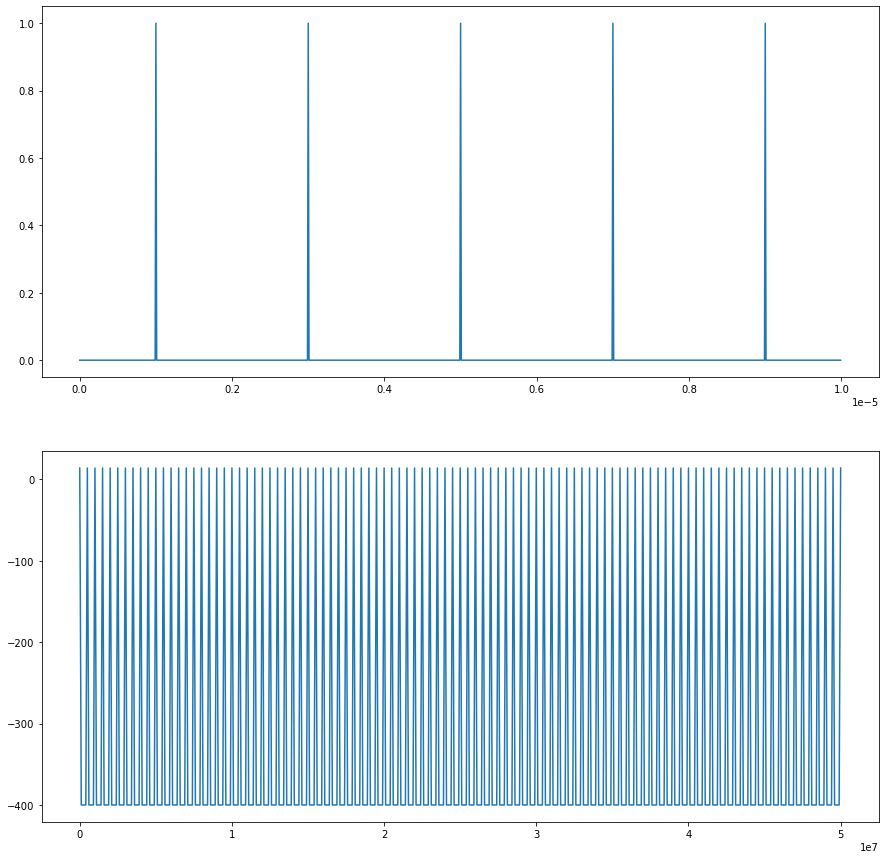

In [67]:
pw= 10e-6
fs = 100e6

test = dirac_comb(pw,fs,5,style="peak") #but fft of a peak- or notch-style comb is the same.....
t = np.arange(0,pw-1/fs,1/fs)
padTest = np.hstack((test[-1],test[:-1]))
raw_fft = np.fft.rfft(padTest)
freq = np.fft.rfftfreq(len(t),d=1/fs)
response = abs(raw_fft)
response[response == 0] = 1e-20

# number of peaks in frequency domain is inversely proportional to number of peaks in time domain
# math SHOULD explain the relationship between the two. It does, it's half of the number of samples between each peak in time domain determines numSpike in freq domain
# So num spikes (+1) and num gaps is spread out from half the sample spacing between peaks across the bandwidth, which is 1/2 sampling rate.
# Ok so number peaks in time domain becomes the MHz spacing between points in freq domain. So if I want 0.5MHz of spacing in freq domain, 
# 100 peaks in a 10e-6 pulse at 100e6 sample rate gives 5+1 peaks in freq domain, spaced 10e6 apart
# 50 peaks in a 10e-6 pulse at 100e6 sample rate gives 10+1 peaks in freq domain, spaced 5e6 apart
# 5 peaks in a 10e-6 pulse at 100e6 sample rate gives 100+1 peaks in freq domain, spaced 0.5e6 apart
# It is definitely ideal that number of peaks divides the sample rate cleanly

# So I have a 10e-6 linearly chirping pulse, and I want to pull 10 spikes out of that linearly chirping pulse
# I decide to do that by taking a spike every 1e-6 of segment, starting at 0.25e-6

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(t,test)
plt.subplot(2,1,2)
plt.plot(freq,20*np.log10(response))

In [70]:
np.arange(0.25,10,1)

array([0.25, 1.25, 2.25, 3.25, 4.25, 5.25, 6.25, 7.25, 8.25, 9.25])